# Chapter 8: Making Transformers Efficient in Production

In [1]:
%%html
<style>
.pad-left {
    padding-left: 20px;
}
</style>

## Background

> (W)hen developing a new machine learning model for your business, do you first make it accurate, then worry about making it fast in production? Or do you first make sure it can be fast, then make it accurate? 
> <p/>
> ...
> <p/>
> While this was a stressful experience for us, it doesn’t have to be for you, because in this article we are going to share the optimizations that made Bert inference fast for us. So you can start with an egg (a known playbook for making certain Bert models fast in production), then focus on the chicken (making your Bert model accurate).

* Blogpost@Robolox: [How We Scaled BERT to Serve 1+ Billion Daily Requests on CPUs](https://medium.com/@quocnle/how-we-scaled-bert-to-serve-1-billion-daily-requests-on-cpus-d99be090db26)
* And the [video from Databricks on YouTube](https://youtu.be/Nw77sEAn_Js)

#### Key takeaways

1. _Smaller Model_: model distillation
1. _Smaller Inputs_: do away with padding inputs and go with dynamically shaped input
1. _Smaller Weights_: although this may necessarily trade off accuracy, use quantization 
1. _Smaller number of requests_: use caching
1. _Smaller number of thread per core_: thread tuning with [`torch.set_num_threads`](https://www.theatlantic.com/ideas/archive/2024/01/the-daily-show-jon-stewart/677240/)

## Intent Detection as a Case Study

In [2]:
from transformers import pipeline

teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=teacher_ckpt)

2024-02-01 04:31:00.903813: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""

pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

### CLINC150

A dataset for task-oriented dialog systems, this dataset was used to fine-tune the baseline model in this example. 

The important thing is that it actually includes queries that are out-of-scope.

Please see: [`clinc_oos` at 🤗](https://huggingface.co/datasets/clinc_oos)

In [4]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

Reusing dataset clinc_oos (/home/a_naughty_alpaca/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [6]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

----

## Creating a Performance Benchmark

In [7]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # tbd
        pass

    def compute_size(self):
        # tbd
        pass

    def time_pipeline(self):
        # tbd
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

#### Implementing `compute_accuracy`

In [8]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

In [9]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)

    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

#### Implementing `compute_size`

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [11]:
import torch

torch.save(pipe.model.state_dict(), "model.pt")

In [12]:
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024*1024)
    # delete tmp file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

#### Implementing `time_pipeline`

In [13]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 56.510
Latency (ms) - 40.367
Latency (ms) - 36.167


In [14]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline method"""
    latencies = []

    # warm-up
    for _ in range(10):
        _ = self.pipeline(query)

    # now we observed the elapsed time over 100 runs
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)

    # compute run stats
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return { "time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms }

PerformanceBenchmark.time_pipeline = time_pipeline

In [15]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 22.95 +\- 0.32
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Creating a Knowledge Distillation Trainer

In addition to the _105_ parameters that [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments), we will add two more to support training of a student model with knowledge distillation:

* `alpha` ... $\alpha$ controls the weighted average of cross-entropy and knowledge-distillation loss for the student model (see below). Ranges from 0.0 to 1.0; $\alpha = 1.0$ means that we only use the cross-entropy of the student and ignore any signal from the teacher.
* `temperature` ... $T$ softens the probability distributions by scaling the logits before applying softmax:

<p class="pad-left">\(p_{i} = \frac{exp(z_i(x)/T)}{\sum_\limits{j}exp(z_{i}(x)/T)}\)</p>
<p>Ranges from 1.0 to $\infty$. $T=1$ recovers the original softmax distribution. </p>

In [16]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

During training, loss is calculated as a weighted average of the usual cross-entropy loss of the student; and the knowledge-distillation loss between the teacher and student. 

<p class="pad-left">\(L_{student} = \alpha L_{CE} + (1 - \alpha) L_{KD}\)</p>
<p>where</p>


<p class="pad-left">\(L_{CE}\)</p>
<p>is the cross-entropy loss of the ground truth labels.</p>

<p class="pad-left">\(L_{KD} = T^{2}D_{KL}\)</p><p>is knowledge-distillation loss where \(T^{2}\) is a normalization factor to account for the gradients produced by soft labels scales as \(\frac{1}{T^{2}}\).</p>

<p class="pad-left">\(D_{KL}(p, q) = \sum_\limits{i} p_i \  log\frac{p_i(x)}{q_i(x)}\)</p>
<p>which is the expectation of the log difference between $p_i(x)$ and $q_i(x)$ when the expectation is taken using the probabilities of $p_i(x)$. For our case, $p_i(x)$ is the <i>teacher</i> and $q_i(x)$ is the <i>student</i>. In other words, we measure loss by seeing how far off the student is from the teacher, and that makes perfect sense.</p>

In [17]:
import torch.nn as nn
import torch.nn.functional as F

from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        
        # extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits

        # soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1)
        )

        # return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

## Choosing a Good Student Initialization

> A good rule of thumb from the literature is that knowledge distillation works best when teacher and student are of the same _model type_.

So if we are using [BERT (`transformersbook/bert-base-uncased-finetuned-clinc`)](https://huggingface.co/transformersbook/bert-base-uncased-finetuned-clinc) for teacher, then [DistilBERT (`distilbert-base-uncased`)](https://huggingface.co/distilbert-base-uncased) for the student is a natural choice.

In [18]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)


clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Parameter 'function'=<function tokenize_text at 0x7f49c430f040> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [20]:
from huggingface_hub import notebook_login

notebook_login()

We implement `compute_metrics` for tracking metrics during training. Here, we can reuse `accuracy_score` which we use above in `PerformanceBenchmark.compute_accuracy`.

In [21]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

#### Training arguments

* [`output_dir`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.output_dir) ... output directory where the model predictions and checkpoints will be written.
* [`evaluation_strategy`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.evaluation_strategy) ... `"no"`: No evaluation is done during training; `"steps"`: Evaluation is done (and logged) every eval_steps; or `"epoch"`: Evaluation is done at the end of each epoch.
* [`num_train_epochs`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.num_train_epochs(float,) ... number of training epochs to perform (if not an integer, will perform the decimal part percents of the last epoch before stopping training); defaults to 3.0.
* [`learning_rate`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.learning_rate) ... initial learning rate for [`transformers.AdamW`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/optimizer_schedules#transformers.AdamW) optimizer.
* [`weight_decay`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.weight_decay) ... weight decay to apply (if not zero) to all layers except all bias and `LayerNorm` weights in `transformers.AdamW` optimizer.
* [`per_device_train_batch_size`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.per_device_train_batch_size) ... batch size per GPU/TPU core/CPU for _training_; defaults to 8.
* [`per_device_eval_batch_size`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.per_device_eval_batch_size) ... batch size per GPU/TPU core/CPU for _evaluation_; defaults to 8.
* `alpha` ... controls the weighted average of cross-entropy and knowledge-distillation loss for the student model (see explanation above).
* `temperature` ... controls the softening of the probability distributions by scaling the logits before applying softmax (see explanation above).
* [`push_to_hub`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.push_to_hub) ... push the model to the Hub every time the model is saved.

In [22]:
SEED = 8675309

In [23]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"

student_training_args = DistillationTrainingArguments(
    seed=SEED,
    output_dir=finetuned_ckpt,
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # here are the 2 hyperparams for knowledge-distillation
    alpha=1,
    temperature=2.0,
    # to avoid those deprecation warnings
    optim="adamw_torch",
    #
    push_to_hub=True
)

#### Student model configuration

In [24]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

num_labels = intents.num_classes

In [25]:
from transformers import AutoConfig

student_config = AutoConfig.from_pretrained(
    student_ckpt,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
from transformers import AutoModelForSequenceClassification

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(
        student_ckpt,
        config=student_config
    ).to(device))

In [28]:
teacher_model = (AutoModelForSequenceClassification.from_pretrained(
    teacher_ckpt,
    num_labels=num_labels
).to(device))

In [29]:
%%time

distilbert_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

distilbert_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initial

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.306145,0.668065
2,3.803300,1.912227,0.827097
3,3.803300,1.195120,0.883226
4,1.732300,0.890680,0.903871
5,0.937100,0.807984,0.908387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-

CPU times: user 5min 5s, sys: 6.51 s, total: 5min 12s
Wall time: 6min 38s


TrainOutput(global_step=1590, training_loss=2.0806282571276777, metrics={'train_runtime': 392.659, 'train_samples_per_second': 194.189, 'train_steps_per_second': 4.049, 'total_flos': 413328758053176.0, 'train_loss': 2.0806282571276777, 'epoch': 5.0})

In [30]:
distilbert_trainer.push_to_hub("Fine-tuned student model training completed")

print("don't forget to add the knowledge-distillation hyperparameters to your model card!")

Saving model checkpoint to distilbert-base-uncased-finetuned-clinc
Configuration saved in distilbert-base-uncased-finetuned-clinc/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json


Upload file runs/Feb01_04-33-55_t4-us-west4-b-n1-standard-16/events.out.tfevents.1706762045.t4-us-west4-b-n1-s…

To https://huggingface.co/buruzaemon/distilbert-base-uncased-finetuned-clinc
   3b81257..f39150d  main -> main



don't forget to add the knowledge-distillation hyperparameters to your model card!


----

#### ???

So, how is that fine-tuned model of ours?

In [31]:
finetuned_ckpt = "buruzaemon/distilbert-base-uncased-finetuned-clinc"

pipe = pipeline(
    "text-classification",
    model=finetuned_ckpt
)

loading configuration file https://huggingface.co/buruzaemon/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/f7e1cbec0db82ab08daffa0c52e1525ccdeaacb9521852321d65babd4fc65057.332a0a2671a37b2b28094f55b6982c2256246ecec6ece34c3e29448b159520ae
Model config DistilBertConfig {
  "_name_or_path": "buruzaemon/distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
 

In [32]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(
    pipe,
    clinc["test"],
    optim_type=optim_type
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 11.99 +\- 0.19
Accuracy on test set - 0.855


### Comparison: base-line model (Teacher) vs. fine-tuned (Student)

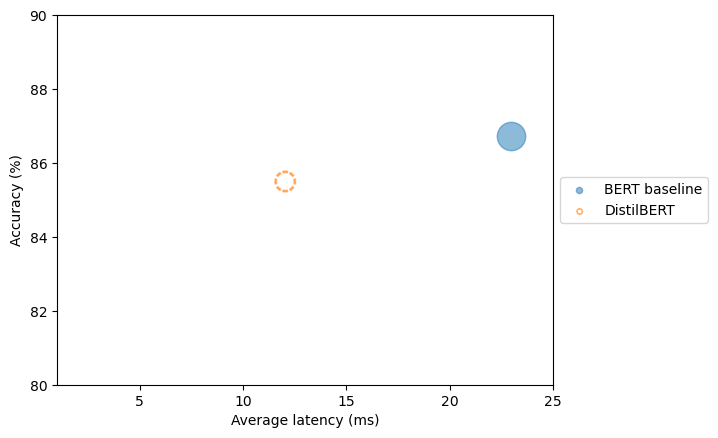

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(
                df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx,
                marker='$\u25CC$'
            )
        else:
            plt.scatter(
                df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx
            )
   
    legend = plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    #for handle in legend.legendHandles:
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80, 90)

    # use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)         

#### Optuna

The default backend for hyperparameter search in HF is Optuna. Pretty neat!

In [34]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x)**2 + 100*(y - x**2)**2

In [35]:
import optuna

# while the logging from Optuna is very interesting,
#                                  ^^^^
# it is also very verbose!
#            ^^^^^^^^^^^^
# uncomment the line below to see it in all its glory
#
#optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-02-01 04:42:25,648] A new study created in memory with name: no-name-0699a764-64b4-4d2e-8215-3f2c05968209
[I 2024-02-01 04:42:25,650] Trial 0 finished with value: 5.027235589188395 and parameters: {'x': -1.2421065441164991, 'y': 1.5442209097979012}. Best is trial 0 with value: 5.027235589188395.
[I 2024-02-01 04:42:25,652] Trial 1 finished with value: 34.2026330381243 and parameters: {'x': -0.3854191667518041, 'y': 0.7167314147687169}. Best is trial 0 with value: 5.027235589188395.
[I 2024-02-01 04:42:25,653] Trial 2 finished with value: 649.4488144705452 and parameters: {'x': 1.7967980159252854, 'y': 0.6813004950790953}. Best is trial 0 with value: 5.027235589188395.
[I 2024-02-01 04:42:25,654] Trial 3 finished with value: 1522.0095350428498 and parameters: {'x': 1.626569104433421, 'y': -1.2550638249791453}. Best is trial 0 with value: 5.027235589188395.
[I 2024-02-01 04:42:25,655] Trial 4 finished with value: 125.90382351269803 and parameters: {'x': 1.4794903370822992, 'y': 1

In [36]:
study.best_params

{'x': 0.9923757174556217, 'y': 0.9856457254219398}

Right, let's use `transformers.Trainer.hyperparameter_search` and Optuna to do a hyperparameter search for the best values (given a range) of:

1. `num_train_epochs`
2. `alpha`
3. `temperature`

We set up a function `hp_space` which returns a `dict` with the target hyperparameter names as keys, with `suggest_*` values. This function is what we pass to `hyperparameter_search` as the [`hp_space`](optuna.logging.set_verbosity(optuna.logging.WARNING)) argument.

In [37]:
def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_float("temperature", 2, 20)
    }

#### For reproducing the results of `hyperparameter_search`

In order to reproduce the results of `hyperparameter_search`, we pass in an additional keyword argument which will automagically be passed to the default Optuna backend as an argument to [`optuna.create_study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html#optuna-study-create-study). 

From this [blogpost Optunaでrandomのseedを固定する方法](https://qiita.com/phorizon20/items/1b795beb202c2dc378ed), something like this is possible for setting the seed that Optuna will use:

    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))

In [38]:
%%time

best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20,
    direction="maximize",
    hp_space=hp_space,
    sampler=optuna.samplers.RandomSampler(seed=SEED)
)

[I 2024-02-01 04:42:39,356] A new study created in memory with name: no-name-91501551-3ed5-4aea-aa26-16e37b2c46ab
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initial

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.209209,0.583871
2,0.333900,0.099307,0.821290
3,0.333900,0.066215,0.875806
4,0.115900,0.049595,0.907097
5,0.073000,0.041509,0.907097
6,0.073000,0.036118,0.914194
7,0.057400,0.033039,0.917419
8,0.050200,0.031541,0.921935
9,0.050200,0.030859,0.922903


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.277097,0.610000
2,0.432500,0.124345,0.817419
3,0.432500,0.079072,0.873548
4,0.145400,0.060340,0.897419
5,0.091000,0.052026,0.902581
6,0.091000,0.049515,0.905806


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.365046,0.625161
2,0.565000,0.144862,0.823226
3,0.565000,0.082723,0.875806
4,0.168900,0.061436,0.903871
5,0.096000,0.052801,0.910323
6,0.096000,0.050211,0.913871


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.193894,0.572903
2,0.310400,0.094275,0.811613
3,0.310400,0.064328,0.871290
4,0.109800,0.049092,0.905484
5,0.070700,0.041398,0.908065
6,0.070700,0.036268,0.913548
7,0.056100,0.033244,0.915806
8,0.049200,0.031803,0.920968
9,0.049200,0.031119,0.921290


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199906,0.568710
2,0.316900,0.099006,0.803226
3,0.316900,0.068649,0.866452
4,0.115100,0.053981,0.898710
5,0.076600,0.046372,0.904194
6,0.076600,0.042511,0.906774
7,0.063400,0.041180,0.908710


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201611,0.561935


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 05:31:15,098] Trial 5 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.258295,0.591935
2,0.400200,0.124571,0.807419


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 05:33:47,270] Trial 6 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from ca

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202373,0.550968


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 05:34:48,004] Trial 7 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.275773,0.600968
2,0.426400,0.129618,0.809032


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 05:37:20,159] Trial 8 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from ca

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.192195,0.576129


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 05:38:20,763] Trial 9 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.208098,0.586129
2,0.333300,0.098023,0.823871
3,0.333300,0.064892,0.876452
4,0.114500,0.048098,0.908710
5,0.071300,0.040034,0.908710
6,0.071300,0.034480,0.916452
7,0.055300,0.031127,0.919032
8,0.047700,0.029510,0.924516
9,0.047700,0.028160,0.926129
10,0.043800,0.027764,0.926129


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-10/checkpoi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.319171,0.630645
2,0.504500,0.123302,0.834516
3,0.504500,0.069785,0.886774
4,0.145400,0.049231,0.914516
5,0.079200,0.041034,0.918710
6,0.079200,0.035827,0.923226
7,0.060400,0.033060,0.924516
8,0.052600,0.031708,0.927742
9,0.052600,0.031145,0.927742


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-11/checkpoi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.233483,0.609032
2,0.372800,0.104714,0.827419
3,0.372800,0.066487,0.881935
4,0.122900,0.048050,0.908710
5,0.073700,0.039710,0.912258
6,0.073700,0.033988,0.920000
7,0.056500,0.030708,0.921290
8,0.048400,0.029156,0.926452
9,0.048400,0.027846,0.927419
10,0.044500,0.027455,0.928065


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-12/checkpoi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201224,0.576452


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 06:17:17,368] Trial 13 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.203813,0.569677


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 06:18:18,148] Trial 14 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.204437,0.552581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 06:19:18,641] Trial 15 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.238547,0.610645
2,0.380600,0.105879,0.829032
3,0.380600,0.066678,0.882258
4,0.124400,0.047958,0.909677
5,0.074000,0.039610,0.913226
6,0.074000,0.033902,0.919677
7,0.056600,0.030634,0.921290
8,0.048600,0.029086,0.927097
9,0.048600,0.027787,0.928710
10,0.044600,0.027402,0.928065


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-16/checkpoi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.246514,0.588065


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 06:33:30,238] Trial 17 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.208468,0.585161


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 06:34:31,079] Trial 18 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.213973,0.590645


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2024-02-01 06:35:31,556] Trial 19 pruned. 


CPU times: user 1h 30min 16s, sys: 1min 32s, total: 1h 31min 48s
Wall time: 1h 52min 52s


In [39]:
print(best_run)

BestRun(run_id='12', objective=0.9280645161290323, hyperparameters={'num_train_epochs': 10, 'alpha': 0.5858821400787321, 'temperature': 4.917005721212045})


In [40]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

distil_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

distil_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initial

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.002947,0.690968
2,2.358500,1.058458,0.862581
3,2.358500,0.600098,0.905806
4,0.937800,0.407230,0.934839
5,0.405300,0.327355,0.938710
6,0.405300,0.295066,0.942581
7,0.243300,0.273408,0.943871
8,0.187100,0.262521,0.945161
9,0.187100,0.256618,0.945161
10,0.166000,0.256465,0.944516


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-1000
Configuration saved in distilbert-

TrainOutput(global_step=3180, training_loss=0.6848866198797646, metrics={'train_runtime': 786.282, 'train_samples_per_second': 193.951, 'train_steps_per_second': 4.044, 'total_flos': 826980744547356.0, 'train_loss': 0.6848866198797646, 'epoch': 10.0})

In [41]:
distil_trainer.push_to_hub("Distilled student model training completed")

print("don't forget to add the knowledge-distillation hyperparameters to your model card! (see best_run)")

Saving model checkpoint to distilbert-base-uncased-distilled-clinc
Configuration saved in distilbert-base-uncased-distilled-clinc/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

To https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc
   b820ac1..a07aa91  main -> main

To https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc
   a07aa91..422575f  main -> main



don't forget to add the knowledge-distillation hyperparameters to your model card! (see best_run)


### Benchmarking Our Distilled Model

In [42]:
distilled_ckpt = "buruzaemon/distilbert-base-uncased-distilled-clinc"

pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"

pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

loading configuration file https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc/resolve/main/config.json from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/440ff9e1a37c55160f5b9f63273c460e8a11b91427d5137024ac04391627b080.332a0a2671a37b2b28094f55b6982c2256246ecec6ece34c3e29448b159520ae
Model config DistilBertConfig {
  "_name_or_path": "buruzaemon/distilbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
 

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc/resolve/main/pytorch_model.bin in cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/276e8f877903dae9bee5d2f28dcf703a974e430630b3491539dac90347fb0d9e.c49a33998a0ce5fd91087350c29aa2e491c1a96c1bb519b84c219bf510f6342f
creating metadata file for /home/a_naughty_alpaca/.cache/huggingface/transformers/276e8f877903dae9bee5d2f28dcf703a974e430630b3491539dac90347fb0d9e.c49a33998a0ce5fd91087350c29aa2e491c1a96c1bb519b84c219bf510f6342f
loading weights file https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc/resolve/main/pytorch_model.bin from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/276e8f877903dae9bee5d2f28dcf703a974e430630b3491539dac90347fb0d9e.c49a33998a0ce5fd91087350c29aa2e491c1a96c1bb519b84c219bf510f6342f
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification wer

Model size (MB) - 255.88
Average latency (ms) - 11.83 +\- 0.20
Accuracy on test set - 0.875


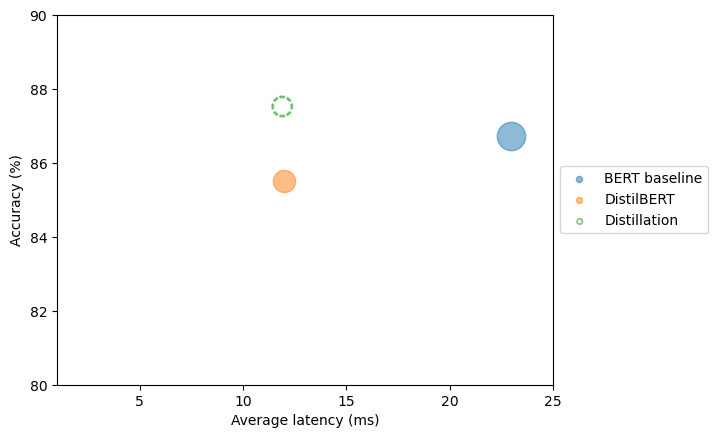

In [43]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

#### The range of model weight values is actually pretty limited.

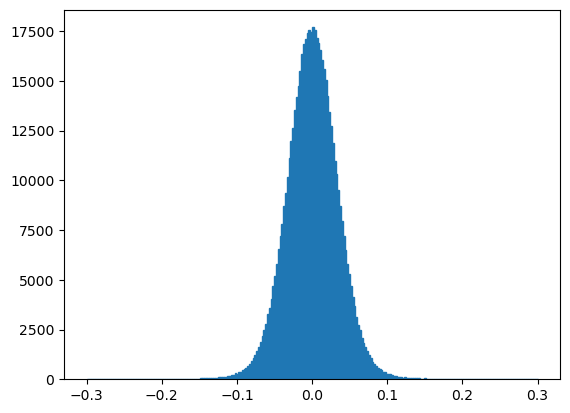

In [44]:
state_dict = pipe.model.state_dict()

weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]

plt.hist(
    weights.flatten().numpy(),
    bins=250,
    range=(-0.3, 0.3),
    edgecolor="C0",
)
plt.show()

_Discretization_ means taking the floating-point values $f$ in a tensor; map their range $\left[ f_{max}, f_{min} \right]$ into a smaller one $\left[ q_{max}, q_{min} \right]$ of fixed-point number $q$; then linearly distributing all values in between (the affine bit).

\begin{align}
  f = \left( \frac{f_{max} - f_{min}}{q_{max} - q_{min}} \right) \left(q - Z\right)
\end{align}

where 

$\left( \frac{f_{max} - f_{min}}{q_{max} - q_{min}} \right)$ is a scaling factor 


and _zero point_ $Z$, of the same type as $q$, is the quantized value of floating-point value $f = 0$.

In [45]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

#### Quantization the hard way

In [46]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -6,  -8,   0,  ...,  -6,  -3,   9],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   6,  -3],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

#### Quantization the PyTorch way

In [47]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -6,  -8,   0,  ...,  -6,  -3,   9],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   6,  -3],
        ...,
        [  6,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [48]:
%%timeit

weights @ weights

1 ms ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [50]:
%%timeit 

q_fn.mul(quantized_weights, quantized_weights)

226 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [51]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/var/tmp/ipykernel_60703/2099325647.py:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [52]:
torch.cuda.empty_cache()

import random
from torch.quantization import quantize_dynamic

# take our last, best model...
model_ckpt = "buruzaemon/distilbert-base-uncased-distilled-clinc"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (
    AutoModelForSequenceClassification
        .from_pretrained(model_ckpt)
        #.to("cpu")
)

model_quantized = quantize_dynamic(
    model,
    {nn.Linear},
    dtype=torch.qint8
)

loading file https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc/resolve/main/vocab.txt from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/d6a6960a277dee54cae995412a5d1d91c3c01a7205ee9a021c5acf723c1009ac.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc/resolve/main/tokenizer.json from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/d765a80fb92038143cb9ca38cacd10d0ef078b1c6be4bf707d68bc482fca65ed.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
loading file https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/buruzaemon/distilbert-base-uncased-distilled-clinc/resolve/main/special_tokens_map.json from cache at /home/a_naughty_alpaca/.cache/huggingface/transformers/830798532de151eb7a28a667da288d249368317cbced033

### Benchmarking Our Quantized Model

In [53]:
pipe = pipeline(
    "text-classification",
    model=model_quantized,
    tokenizer=tokenizer
)

optim_type = "Distillation + quantization"

pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 8.68 +\- 0.18
Accuracy on test set - 0.885


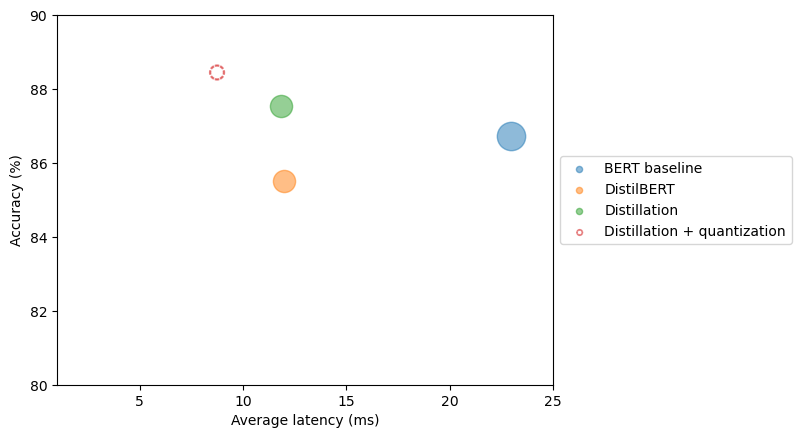

In [54]:
plot_metrics(perf_metrics, optim_type)

## Optimizing Inference with ONNX and the ONXX Runtime